In [2]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-05-24 14:22:05.565539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
start = pd.to_datetime('2010-08-02')
end = pd.to_datetime('2018-08-04')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
dates = data.index
columns = data.columns
data.index.name = "Date" #add date as column
data.reset_index(inplace = True)
data.index.name = "timeT" #add time as column
data.reset_index(inplace = True)
print(data.head())


[*********************100%***********************]  1 of 1 completed
   timeT       Date       Open       High        Low      Close  Adj Close  \
0      0 2010-08-02  12.179100  12.285949  12.128041  12.214467  12.214467   
1      1 2010-08-03  12.216709  12.265526  12.123558  12.200021  12.200021   
2      2 2010-08-04  12.258552  12.627668  12.230407  12.610732  12.610732   
3      3 2010-08-05  12.600022  12.667519  12.541990  12.655066  12.655066   
4      4 2010-08-06  12.587818  12.596286  12.354941  12.458801  12.458801   

      Volume  
0   74626675  
1   72362219  
2  153071607  
3   97178890  
4  133277692  


<Axes: >

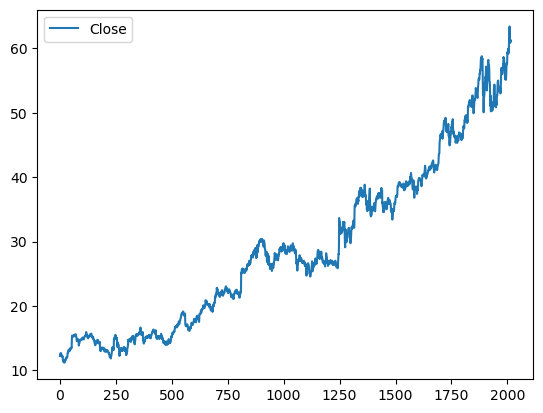

In [4]:
seaborn.lineplot(data.loc[:,["Close"]]) #plot the value of close

In [5]:
##first let us fit log(Y) = t + c, with Y value of the stock and t the time and c some constant
PF = np.polyfit(data.loc[:,"timeT"], np.log(data.loc[:,"Close"]), 1)
PF

array([7.73868122e-04, 2.48282566e+00])

In [6]:
#use the estimates to calculate the curve
dfTrySomething = data.loc[:,["Close", "timeT"]]
dfTrySomething["Estimate"] = np.exp(PF[0]*dfTrySomething["timeT"]+PF[1])
dfTrySomething["NoExp"] = dfTrySomething["Close"]/dfTrySomething["Estimate"] ##devide by trend

<Axes: ylabel='NoExp'>

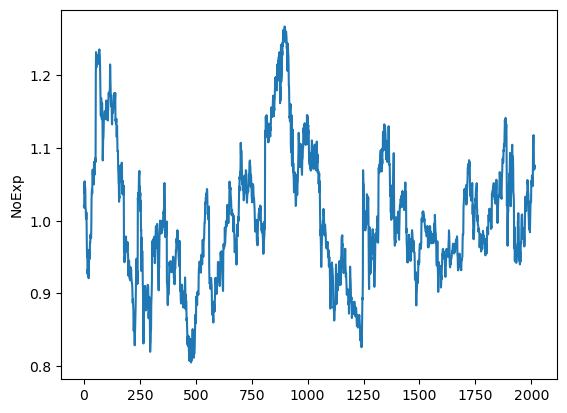

In [7]:
# plot the line with the trend removed
seaborn.lineplot((dfTrySomething.loc[:,"NoExp"]))

<Axes: >

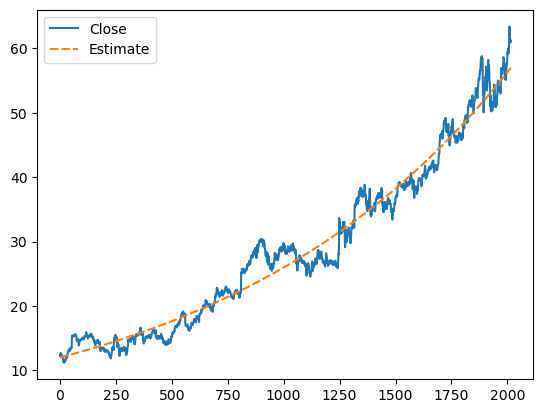

In [8]:
seaborn.lineplot(dfTrySomething.loc[:,["Close","Estimate"]])

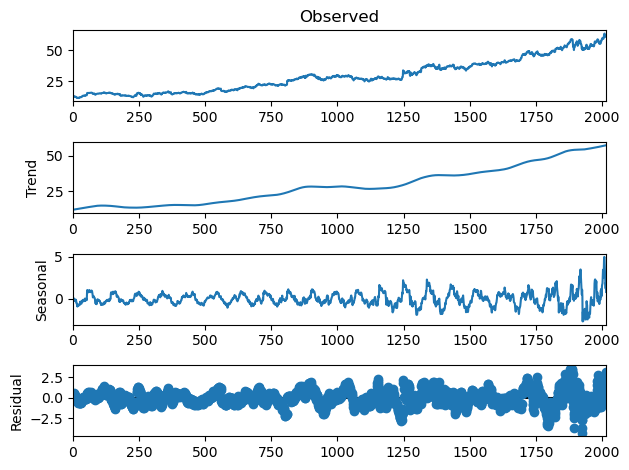

In [9]:
##something we did not full understand. Something with seasonality, however above doesnt nescessary show seasonality

from statsmodels.tsa.seasonal import STL

closeFrame = dfTrySomething.loc[:,"Close"]
closeFrame.index = [i for i in range(closeFrame.shape[0])]

res = STL(np.array(closeFrame), period=90).fit()
fig = res.plot()

/Users/lars/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


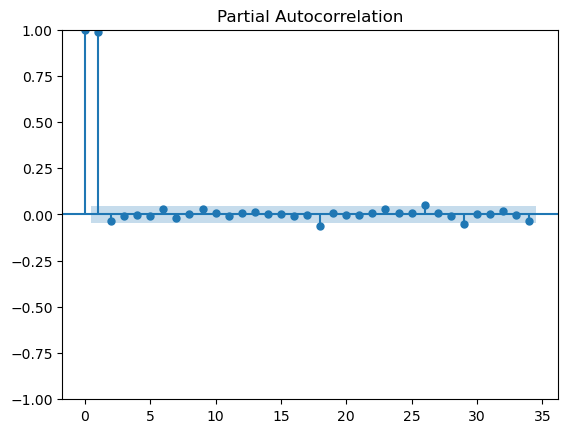

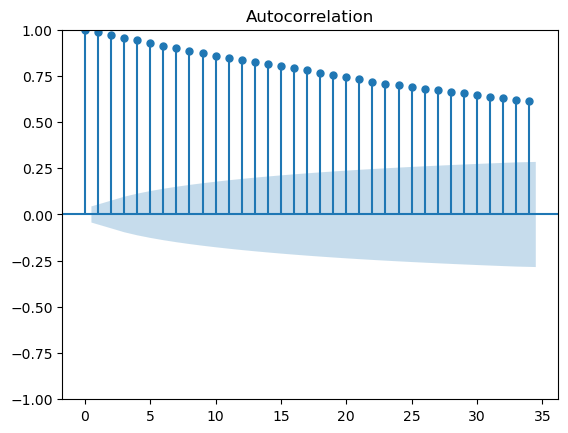

In [10]:
#needed for ARMA model
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


plot_pacf(dfTrySomething['NoExp'].dropna());
plot_acf(dfTrySomething['NoExp'].dropna());

ad_fuller_result = adfuller(dfTrySomething['NoExp'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [91]:
from sklearn.model_selection import train_test_split
import numpy as np

# set desired prediction window
n = 5

# Set 'Date' column as the index of the data
data.set_index(data['Date'], drop=False, append=False, inplace=False, verify_integrity=False)

# Calculate the split index for 80/20 split, considering multiples of 5
split_index = int(len(data) * 0.8) // n * n
end_index = data.shape[0] // n * n

# Set train and test data based on calculated indexes
data_clean = data[['Close', 'Open', 'High', 'Low', 'Volume']]
train = data_clean[:split_index]
test = data_clean[split_index:end_index]

# # # Split the data into input features (X) and target variable (y) where X is t-1 and y = t
# X = data[['Close', 'Open', 'High', 'Low', 'Volume']]
# y = data[['Close']].iloc[1: , :]

# # Split the input features and target variable into training and testing subsets
# X_train = X[:split_index]
# X_test = X[split_index:end_index]

# y_train = y[:split_index]
# y_test = y[split_index:end_index]

# # Split the training and testing subsets into arrays of 5 datapoints
# X_train = np.array(np.split(X_train, len(X_train) / 5))
# X_test = np.array(np.split(X_test, len(X_test) / 5))

# y_train = np.array(np.split(y_train, len(y_train) / 5))
# y_test = np.array(np.split(y_test, len(y_test) / 5))

In [84]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import LSTM

def to_supervised(train, n_input, n_out=5):
    X, y = list(), list()
    in_start = 0

    for i in range(len(train)):
        in_end = i + n_input
        out_end = in_end + n_out

        if out_end <= len(train):
            x_input = train[in_start:in_end, :]  # Extract input sequence
            x_input = x_input.reshape((len(x_input), 1))  # Reshape input sequence to fit the LSTM model
            X.append(x_input)  # Add input sequence to X
            y.append(data[in_end:out_end], 0)  # Add output sequence to y
        
    return np.array(X), np.array(y)

def build_model(train, n_input):
    # prepare data
    x_train, y_train = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 2, 50, 72
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_timesteps, n_features)))  # Add LSTM layer with 50 units
    model.add(RepeatVector(n_outputs))  # Repeat the output sequence
    model.add(Dense(1))  # Add a dense layer with 1 unit
    model.compile(loss='mae', optimizer='adam')  # Compile the model with mean absolute error loss and Adam optimizer
    # fit network
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)  # Train the model

    return model
